<a href="https://colab.research.google.com/github/Pallavi5775/text-gen/blob/main/aging_faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision tensorflow keras numpy matplotlib opencv-python


In [460]:
import cv2
import os
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!cd "/content/drive/My Drive/image_parts" && ls -lh


total 1.8G
-rw------- 1 root root 100M Dec 28 10:38 images.z01
-rw------- 1 root root 100M Dec 28 10:38 images.z02
-rw------- 1 root root 100M Dec 28 10:38 images.z03
-rw------- 1 root root 100M Dec 28 10:39 images.z04
-rw------- 1 root root 100M Dec 28 10:39 images.z05
-rw------- 1 root root 100M Dec 28 10:39 images.z06
-rw------- 1 root root 100M Dec 28 10:39 images.z07
-rw------- 1 root root 100M Dec 28 10:39 images.z08
-rw------- 1 root root 100M Dec 28 10:39 images.z09
-rw------- 1 root root 913M Dec 28 12:07 images.zip


In [ ]:
!unzip -tq "/content/drive/Shared with me/images.zip"


No errors detected in compressed data of /content/drive/My Drive/image_parts/images.zip.


In [ ]:
!unzip "/content/drive/My Drive/image_parts/images.zip" -d "/content/dataset"


Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/images/3_0_2_20161219141852353.jpg  
  inflating: /content/dataset/images/3_0_2_20161219142321097.jpg  
  inflating: /content/dataset/images/3_0_2_20161219142512185.jpg  
  inflating: /content/dataset/images/3_0_2_20161219142551561.jpg  
  inflating: /content/dataset/images/3_0_2_20161219142553649.jpg  
  inflating: /content/dataset/images/3_0_2_20161219151511755.jpg  
  inflating: /content/dataset/images/3_0_2_20161219151938084.jpg  
  inflating: /content/dataset/images/3_0_2_20161219153035532.jpg  
  inflating: /content/dataset/images/3_0_2_20161219154525565.jpg  
  inflating: /content/dataset/images/3_0_2_20161219160003893.jpg  
  inflating: /content/dataset/images/3_0_2_20161219160259510.jpg  
  inflating: /content/dataset/images/3_0_2_20161219160753533.jpg  
  inflating: /content/dataset/images/3_0_2_20161219160801053.jpg  
  inflating: /content/dataset/images/3_0_2_20161219161653119.jpg  
  inflating

In [461]:
import cv2
import os
import numpy as np

def preprocess_images(image_dir, output_size=(128, 128)):
    """
    Preprocess images by resizing, normalizing, and categorizing into age groups.

    Parameters:
    - image_dir: Directory containing the images.
    - output_size: Desired size for all images (width, height).

    Returns:
    - images: Array of preprocessed images.
    - labels: Array of corresponding age group labels.
    """
    images, labels = [], []
    for file_name in os.listdir(image_dir):
        file_path = os.path.join(image_dir, file_name)

        # Load image
        img = cv2.imread(file_path)
        if img is not None:
            # Resize image
            img = cv2.resize(img, output_size)

            # Normalize pixel values to [-1, 1]
            img = img / 127.5 - 1

            # Extract age from filename (assuming filenames like '25_1.jpg')
            try:
                age = int(file_name.split('_')[0])  # Parse age from filename
                age_group = age // 10  # Categorize into age groups (0-10, 11-20, ...)
                images.append(img)
                labels.append(age_group)
            except ValueError:
                print(f"Skipping file {file_name}: Unable to extract age")

    return np.array(images), np.array(labels)

# Example usage
image_dir = "/content/dataset/images"
images, labels = preprocess_images(image_dir)

print(f"Preprocessed {len(images)} images.")
print(f"Labels: {np.unique(labels)}")


Preprocessed 12051 images.
Labels: [ 0  1  2  3  4  5  6  7  8  9 10 11]


In [462]:
from torchvision.models import resnet18
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, input_dim, label_dim, output_dim):
        super(Generator, self).__init__()

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(input_dim + label_dim, 256 * 4 * 4),
            nn.ReLU()
        )
        nn.init.xavier_uniform_(self.fc[0].weight)
        nn.init.zeros_(self.fc[0].bias)

        # Deconvolutional layers
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.GroupNorm(num_groups=32, num_channels=128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.GroupNorm(num_groups=32, num_channels=64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.GroupNorm(num_groups=16, num_channels=32),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=16),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, output_dim, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, noise, labels):
          # Ensure inputs are float32 for fully connected layers
          # noise = noise.float()
          # labels = labels.float()

          if noise.dtype != labels.dtype:
               labels = labels.to(noise.dtype)  # Match dtype of noise

          print(f"Noise shape: {noise.shape}, dtype: {noise.dtype}")  # Expected: [batch_size, latent_dim]
          print(f"Labels shape: {labels.shape}, dtype: {labels.dtype}")  # Expected: [batch_size, num_classes]

          # Concatenate noise and labels
          combined = torch.cat([noise, labels], dim=1)  # Shape: [batch_size, input_dim + label_dim]
          combined = torch.clamp(combined, min=-1, max=1)  # Clamp to prevent large values
          print("Generator Forward Pass:")
          print(f"Combined input min: {combined.min()}, max: {combined.max()}, dtype: {combined.dtype}")

          # Pass through fully connected layer
          out = self.fc(combined)  # Output will be float32
          out = torch.clamp(out, min=-10, max=10)  # Constrain extreme values
          print(f"FC output min: {out.min()}, max: {out.max()}, dtype: {out.dtype}")

          if torch.isnan(out).any() or torch.isinf(out).any():
              print("NaN or Inf detected in fc output!")
              return out

          # Reshape for deconvolution
          batch_size = out.size(0)
          out = out.view(batch_size, 256, 4, 4)  # Reshape into [batch_size, channels, height, width]
          print(f"Reshaped output min: {out.min()}, max: {out.max()}, dtype: {out.dtype}")

                # Deconvolutional layers
          for i, layer in enumerate(self.deconv):
              out = layer(out)
              if torch.isnan(out).any() or torch.isinf(out).any():
                  print(f"NaN or Inf detected in Deconv Layer {i}!")
                  return out

          return out









In [463]:
class Discriminator(nn.Module):
    def __init__(self, input_channels, label_channels):
        super(Discriminator, self).__init__()



        # Define convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(13, 64, kernel_size=4, stride=2, padding=1),  # 13 input channels # [13, 128, 128] -> [64, 64, 64]
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )

        print(self.conv_layers[0])


        # Define a fully connected layer for classification
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 8 * 8, 1),  # Adjust based on the output size of conv layers
        )

    def forward(self, x, labels):
          # Ensure inputs are float32
          x = x.float()
          labels = labels.float()

          # Concatenate inputs and labels
          combined = torch.cat([x, labels], dim=1)  # Shape: [batch_size, input_channels + label_channels, height, width]
          print("Discriminator Forward Pass:")
          print(f"Combined input min: {combined.min()}, max: {combined.max()}, dtype: {combined.dtype}")

          # Pass through convolutional layers
          out = self.conv_layers(combined)
          print(f"Conv output min: {out.min()}, max: {out.max()}, dtype: {out.dtype}")

          # Flatten and pass through the final fully connected layer
          out = self.fc(out.view(out.size(0), -1))  # Shape: [batch_size, 1]
          print(f"Final output min: {out.min()}, max: {out.max()}, dtype: {out.dtype}")

          return out




In [464]:
def wasserstein_loss(real_preds, fake_preds):
    # Real loss: maximize the output for real data
    real_loss = -torch.mean(real_preds)
    # Fake loss: minimize the output for fake data
    fake_loss = torch.mean(fake_preds)
    return real_loss + fake_loss

def gradient_penalty(discriminator, real_data, fake_data, labels, device):
    batch_size = real_data.size(0)
    epsilon = torch.rand(batch_size, 1, 1, 1, device=device).float()

    # Interpolation between real and fake data
    interpolates = epsilon * real_data + ((1 - epsilon) * fake_data)
    interpolates.requires_grad_(True)

    # Forward pass through discriminator
    interpolates_preds = discriminator(interpolates.float(), labels.float())

    # Compute gradients
    gradients = torch.autograd.grad(
        outputs=interpolates_preds,
        inputs=interpolates,
        grad_outputs=torch.ones_like(interpolates_preds),
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]

    # Compute gradient penalty
    gradients = gradients.view(batch_size, -1)
    gradient_norm = gradients.norm(2, dim=1)
    gradient_penalty = ((gradient_norm - 1) ** 2).mean()

    return gradient_penalty


In [504]:
import torch.nn.functional as F


def train_gan(generator, discriminator, dataloader, epochs, device, lambda_gp=1, accumulation_steps=1):
    generator = generator.to(device).float()  # Move generator to device with half precision
    discriminator = discriminator.to(device).float()  # Move discriminator to device with full precision

    g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))
    criterion = nn.BCEWithLogitsLoss()  # Use BCE loss for stability

    scaler = torch.amp.GradScaler()  # Gradient scaler for mixed precision

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        d_loss_epoch, g_loss_epoch = 0.0, 0.0  # Track average losses for the epoch

        for i, (real_images, labels) in enumerate(dataloader):
            # Move real images and labels to device
            real_images = real_images.to(device).float()  # Half precision for generator
            real_images = real_images / 127.5 - 1.0
            labels = labels.to(device)

            noise = torch.randn(real_images.size(0), 100).to(device).float()  # Noise in half precision
            noise = (noise - noise.mean()) / (noise.std() + 1e-8)  # Normalize noise
            # Ensure labels are in the valid range for one-hot encoding
            if labels.max() >= 10 or labels.min() < 0:
                print(f"Invalid labels found: {labels.unique()}")  # Debugging
                labels = labels % 10  # Example: Map labels to the range [0, 9]

            labels_generator = F.one_hot(labels.long(), num_classes=10).float().to(device)

            with torch.amp.autocast(device_type='cuda', enabled=False):  # Use full precision
                  fake_images = generator(noise, labels_generator).detach().float()  # Detach and convert to full precision
                  fake_images = torch.clamp(fake_images, min=0, max=1)  # Clamp fake images to stable range

                  # Expand labels for the discriminator
                  labels_expanded = labels_generator.unsqueeze(2).unsqueeze(3)
                  labels_expanded = labels_expanded.expand(-1, -1, real_images.size(2), real_images.size(3))
                  # Discriminator predictions
                  real_preds = discriminator(real_images.float(), labels_expanded.float()) # Convert real images to float32
                  fake_preds = discriminator(fake_images.float(), labels_expanded.float())  # Fake images are already in float32

                  # Debugging shapes
                  print(f"real_preds shape: {real_preds.shape}")
                  print(f"fake_preds shape: {fake_preds.shape}")

                  # Clamp predictions for stability
                  real_preds = torch.clamp(real_preds, min=-10, max=10)
                  fake_preds = torch.clamp(fake_preds, min=-10, max=10)

                  # Ensure target shapes match predictions
                  real_target = torch.ones_like(real_preds).view_as(real_preds)
                  fake_target = torch.zeros_like(fake_preds).view_as(fake_preds)

                  print(f"real_target shape: {real_target.shape}")
                  print(f"fake_target shape: {fake_target.shape}")

                  # Compute discriminator loss
                  real_target = torch.ones_like(real_preds)
                  fake_target = torch.zeros_like(fake_preds)
                  d_loss = criterion(real_preds, real_target) + criterion(fake_preds, fake_target)

                  # Compute gradient penalty
                  gp = gradient_penalty(discriminator, real_images.float(), fake_images, labels_expanded, device)
                  if torch.isnan(gp) or torch.isinf(gp):
                      print(f"Gradient penalty is NaN or Inf! Value: {gp}")
                      break
                  gp = torch.clamp(gp, max=10)  # Constrain the gradient penalty to avoid large values
                  d_loss += lambda_gp * gp


            scaler.scale(d_loss).backward()  # Backpropagation with scaled gradients

            for name, param in discriminator.named_parameters():
                if param.grad is not None:
                    print(f"Discriminator Gradient {name}: min={param.grad.min()}, max={param.grad.max()}")
                    if torch.isnan(param.grad).any():
                        print(f"Discriminator Gradient {name} contains NaN!")



            if (i + 1) % accumulation_steps == 0:
                scaler.unscale_(d_optimizer)
                torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=1.0)  # Clip gradients
                scaler.step(d_optimizer)  # Update optimizer
                scaler.update()
                d_optimizer.zero_grad()

            ### Train Generator ###
            noise = torch.randn(real_images.size(0), 100).to(device).float()


            with torch.amp.autocast(device_type='cuda', enabled=False):  # Use full precision


                  labels_generator = torch.clamp(labels_generator, min=0, max=1)

                  if torch.isnan(noise).any() or torch.isinf(noise).any():
                      print("Noise contains NaN or Inf!")
                      break

                  if torch.isnan(labels_generator).any() or torch.isinf(labels_generator).any():
                      print("Labels contain NaN or Inf!")
                      break


                  fake_images = generator(noise.float(), labels_generator.float())  # Fake images stay in half precision for generator updates

                  if torch.isnan(fake_images).any() or torch.isinf(fake_images).any():
                          print("Generator outputs contain NaN or Inf!")
                          break
                  fake_images = torch.clamp(fake_images, min=0, max=1)  # Clamp fake images to stable range

                  labels_expanded = labels_generator.unsqueeze(2).unsqueeze(3)
                  labels_expanded = labels_expanded.expand(-1, -1, fake_images.size(2), fake_images.size(3))
                  fake_preds = discriminator(fake_images.float(), labels_expanded)  # Convert to float32 for discriminator

                  # Reshape the target tensor to match fake_preds
                  target = torch.ones_like(fake_preds)  # Target tensor for generator
                  target = target.view_as(fake_preds)   # Ensure dimensions match

                  # Compute generator loss
                  g_loss = criterion(fake_preds, torch.ones_like(fake_preds))

            scaler.scale(g_loss).backward()  # Backpropagation with scaled gradients

            # Monitor generator gradients
            for name, param in generator.named_parameters():
                if param.grad is not None:
                    print(f"Generator Gradient {name}: min={param.grad.min()}, max={param.grad.max()}")
                    if torch.isnan(param.grad).any():
                        print(f"Generator Gradient {name} contains NaN!")




            if (i + 1) % accumulation_steps == 0:
                scaler.unscale_(g_optimizer)
                for name, param in generator.named_parameters():
                  if param.grad is not None:
                      print(f"{name} grad min: {param.grad.min()}, max: {param.grad.max()}")
                      if torch.isnan(param.grad).any():
                          print(f"{name} gradient contains NaN!")
                          break
                torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)  # Clip gradients
                for name, param in generator.named_parameters():
                      if param.grad is not None:
                          print(f"{name} grad min after clipping: {param.grad.min()}, max: {param.grad.max()}")
                scaler.step(g_optimizer)  # Update optimizer
                scaler.update()
                g_optimizer.zero_grad()

            # Update epoch losses
            d_loss_epoch += d_loss.item()
            g_loss_epoch += g_loss.item()

        # Average losses for the epoch
        d_loss_epoch /= len(dataloader)
        g_loss_epoch /= len(dataloader)

        print(f"Epoch {epoch + 1}: D Loss: {d_loss_epoch:.4f}, G Loss: {g_loss_epoch:.4f}")


In [505]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Define device (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [498]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)  # Xavier initialization
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)



In [506]:
# Initialize generator and discriminator
generator = Generator(input_dim=100, label_dim=10, output_dim=3).to(device)
generator.apply(weights_init)
discriminator = Discriminator(input_channels=3, label_channels=1)



Conv2d(13, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))


In [480]:

import cv2
import torch
from torchvision import transforms
import os

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, transform=None):
        """
        Args:
            image_dir (str): Path to the directory with images.
            transform (callable, optional): Transform to be applied to each image.
        """
        self.image_dir = image_dir
        self.file_names = os.listdir(image_dir)
        self.transform = transform

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        # Get image path
        img_path = os.path.join(self.image_dir, self.file_names[idx])

        # Read image
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError(f"Failed to load image: {img_path}")

        # Convert BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Extract label from filename (e.g., '25_1.jpg' -> 25)
        try:
            label = int(self.file_names[idx].split('_')[0])  # Parse label (e.g., age or category)
        except ValueError:
            label = -1  # Assign a default value if label parsing fails

        # Apply transformations
        if self.transform:
            img = self.transform(img)

        return img, label





In [481]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),  # Normalizes to [0, 1]
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])



In [482]:
dataset = ImageDataset("/content/dataset/images", transform=transform)

In [483]:
from sklearn.utils import resample

# Collect all labels first (assuming labels are provided)
labels = [...]  # Replace with your labels corresponding to the dataset

# Oversample rare classes
augmented_indices = []
for cls in set(labels):
    class_indices = [i for i, label in enumerate(labels) if label == cls]
    if len(class_indices) < 2:
        # Duplicate the sample to meet the minimum requirement
        class_indices = resample(class_indices, replace=True, n_samples=2)
    augmented_indices.extend(class_indices)

import pickle

with open("augmented_indices.pkl", "wb") as f:
    pickle.dump(augmented_indices, f)

In [507]:
from torch.utils.data import Subset
import pickle
with open("augmented_indices.pkl", "rb") as f:
    augmented_indices = pickle.load(f)
augmented_dataset = Subset(dataset, augmented_indices)

In [508]:
from torch.utils.data import DataLoader

dataloader = DataLoader(
    augmented_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2,  # Reduce number of workers
    prefetch_factor=4,  # Prefetch more batches
    pin_memory=True  # Speeds up data transfer to GPU
)

In [509]:
epochs = 20
accumulation_steps = 4
train_gan(generator, discriminator, dataloader, epochs, device, accumulation_steps)

Epoch 1/20
Invalid labels found: tensor([35])
Noise shape: torch.Size([2, 100]), dtype: torch.float32
Labels shape: torch.Size([2, 10]), dtype: torch.float32
Generator Forward Pass:
Combined input min: -1.0, max: 1.0, dtype: torch.float32
FC output min: 0.0, max: 0.6414147615432739, dtype: torch.float32
Reshaped output min: 0.0, max: 0.6414147615432739, dtype: torch.float32
Discriminator Forward Pass:
Combined input min: -1.0078431367874146, max: 1.0, dtype: torch.float32
Conv output min: -1.31317138671875, max: 4.939703941345215, dtype: torch.float32
Final output min: 0.38429516553878784, max: 0.38429516553878784, dtype: torch.float32
Discriminator Forward Pass:
Combined input min: 0.0, max: 1.0, dtype: torch.float32
Conv output min: -0.8673157095909119, max: 4.187019348144531, dtype: torch.float32
Final output min: 0.5275962352752686, max: 0.8458513617515564, dtype: torch.float32
real_preds shape: torch.Size([2, 1])
fake_preds shape: torch.Size([2, 1])
real_target shape: torch.Size([

Noise shape: torch.Size([8, 100]), dtype: torch.float32
Labels shape: torch.Size([8, 10]), dtype: torch.float32
Generator Forward Pass:
Combined input min: -1.0, max: 1.0, dtype: torch.float32
FC output min: 0.0, max: 0.6630910634994507, dtype: torch.float32
Reshaped output min: 0.0, max: 0.6630910634994507, dtype: torch.float32


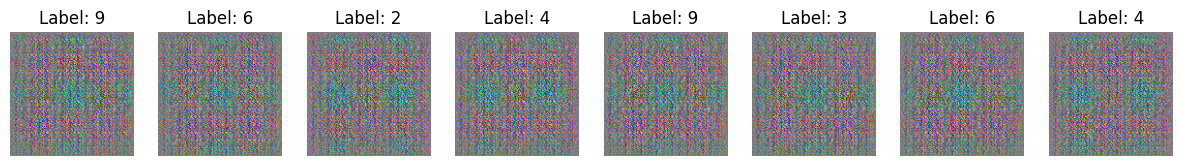

In [510]:
import matplotlib.pyplot as plt

def visualize_generated_images(generator, device, num_images=8, noise_dim=100, labels=None):
    noise = torch.randn(num_images, noise_dim).to(device)
    if labels is None:
        labels = torch.randint(0, 10, (num_images,)).to(device)
    with torch.no_grad():
        fake_images = generator(noise, F.one_hot(labels, num_classes=10).float().to(device))
        fake_images = (fake_images + 1) / 2  # Rescale to [0, 1]

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for img, label, ax in zip(fake_images, labels, axes):
        ax.imshow(img.permute(1, 2, 0).cpu().numpy())
        ax.set_title(f"Label: {label.item()}")
        ax.axis("off")
    plt.show()
visualize_generated_images(generator,device)

In [487]:
torch.save(generator.state_dict(), "generator.pth")
torch.save(discriminator.state_dict(), "discriminator.pth")

In [488]:
generator.load_state_dict(torch.load("generator.pth"))
discriminator.load_state_dict(torch.load("discriminator.pth"))

<ipython-input-488-c05d86176831>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("generator.pth"))
<ipython-input-488-c05d86176831>:2: 

<All keys matched successfully>

In [489]:
# Load the trained generator
generator = Generator(input_dim=100, label_dim=10, output_dim=3).to(device)
generator.load_state_dict(torch.load("generator.pth"))
generator.eval()

<ipython-input-489-f4c980f3b1a5>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("generator.pth"))


Generator(
  (fc): Sequential(
    (0): Linear(in_features=110, out_features=4096, bias=True)
    (1): ReLU()
  )
  (deconv): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): GroupNorm(32, 128, eps=1e-05, affine=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): GroupNorm(32, 64, eps=1e-05, affine=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): GroupNorm(16, 32, eps=1e-05, affine=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): GroupNorm(8, 16, eps=1e-05, affine=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(16, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): Tanh()
  )
)

In [490]:
# Example: Load a single face image
import torchvision.transforms as transforms
from PIL import Image

# Load and preprocess an input face image
image_path = "/content/dataset/images/100_1_0_20170110183726390.jpg"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])

face_image = transform(Image.open(image_path)).unsqueeze(0).to(device)  # Shape: [1, 3, 128, 128]


Noise shape: torch.Size([8, 100]), dtype: torch.float32
Labels shape: torch.Size([8, 10]), dtype: torch.float32
Generator Forward Pass:
Combined input min: -1.0, max: 1.0, dtype: torch.float32
FC output min: 0.0, max: 0.7299325466156006, dtype: torch.float32
Reshaped output min: 0.0, max: 0.7299325466156006, dtype: torch.float32


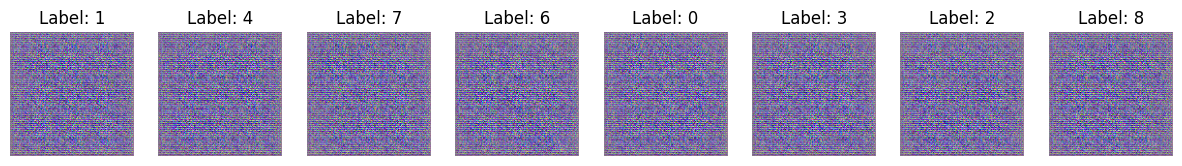

In [491]:
import matplotlib.pyplot as plt

# Function to generate and display images
def visualize_generated_images(generator, device, num_samples=8):
    generator.eval()
    noise = torch.randn(num_samples, 100).to(device).float()
    labels = torch.randint(0, 10, (num_samples,)).to(device)  # Random labels
    labels_one_hot = F.one_hot(labels, num_classes=10).float().to(device)

    with torch.no_grad():
        fake_images = generator(noise, labels_one_hot).cpu()
        fake_images = (fake_images + 1) / 2  # Rescale to [0, 1]

    fig, axs = plt.subplots(1, num_samples, figsize=(15, 5))
    for i in range(num_samples):
        axs[i].imshow(fake_images[i].permute(1, 2, 0))
        axs[i].axis('off')
        axs[i].set_title(f"Label: {labels[i].item()}")
    plt.show()

# Call the visualization function
visualize_generated_images(generator, device)

